In [1]:
# MNIST has 70k images of handwritten digits
# 60k for training, 10k for testing
# grayscale, 28x28 pixels, centered

import torch # deep learning framework w/ dynamic execution graphs
print(torch.__version__)
import torchvision # allows us to load dataset MNIST
import torchvision.transforms as transforms
import torchvision.datasets as datasets 

1.7.0


### Load data

In [2]:
# learning_rate and momentum are hyperparameters for the optimizer

n_epochs = 3 # number of times looping over training set
batch_size_train = 64 
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5 # added to SGD to accelerate grad vector in the right direction (opt algo)
log_interval = 10 # what does this mean?

random_seed = 1 # must set seed for anything using random number generation
torch.backends.cudnn.enabled = False # cuDNN uses nondeterministic algos which we disable
# cuDNN is a wrapper for cuDNN library, which is optimized library for CUDA containing GPU implementations for CNNS
torch.manual_seed(random_seed) #this sets seed of rand generator to fixed val, so that results are reproducible each time (epoch?)

In [3]:
# 0.1307 and 0.3081 are global mean and stdev of the MNIST dataset
#this is a combo of the loading tutorial and the solution tutorial
train_loader = torch.utils.data.DataLoader(datasets.MNIST(root='./data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])), batch_size=batch_size_train, shuffle=True)
print(len(train_loader)) #total MNIST size / batch size

test_loader = torch.utils.data.DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])), batch_size=batch_size_test, shuffle=True)
print(len(test_loader)) #where is MNIST downloaded to? ask for exam

938
10


In [4]:
examples = enumerate(test_loader) # enumerate allows us to count objects or start at spec index
batch_idx, (example_data, example_targets) = next(examples) #what does this line actually do?
example_data.shape #means one test batch has 1000 examples of 28x28 pxs in greyscale (1)


torch.Size([1000, 1, 28, 28])

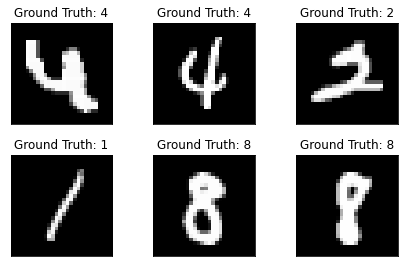

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt

#what are all these details here?

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig = plt.figure()

Building the Network

In [6]:
import torch.nn as nn #contains trainable params
import torch.nn.functional as F #purely functional
import torch.optim as optim

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x): #forward pass defines way compute output w/ layers and funcs
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum= momentum)

### Training the Model

In [9]:
# make sure network is in training mode

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs +1)]

#Iterate over all trianing data once per epoch

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

            torch.save(network.state_dict(), 'model.pth') #.state_dict() save and load internal state
            torch.save(optimizer.state_dict(), 'optimizer.pth')
            

### Test Loop

In [10]:
def test(): # sum up test loss and keep track of correctly classified digits to compute network accuracy
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0F}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [11]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

<ipython-input-7-af7c11e03f8f>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/jbalowski1459/anaconda3/envs/MSNE_CS/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368649
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298366
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.294433
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.260970
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.295451
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.239506
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.274136
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.225711
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.168033
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.138118
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.061368
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.945130
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.949193
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.750879
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.642634
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.585531
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.416778
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.314596
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.256788
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.537450
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.273124
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.440350
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.323490
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.403446
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.328784
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.305339
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.289879
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.343214
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.166507
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.329770
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.271235
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.335641
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.214075
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.588666
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.500673
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.377902
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.423132
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.482833
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.352499


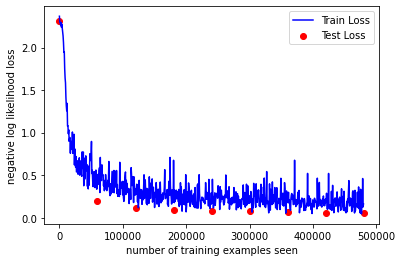

<Figure size 432x288 with 0 Axes>

In [19]:

plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

fig = plt.figure()
# test loss - measure of error encountered while predicting test cases
# train loss - measure of error encountered while training

In [13]:
with torch.no_grad():
    output = network(example_data)

<ipython-input-7-af7c11e03f8f>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


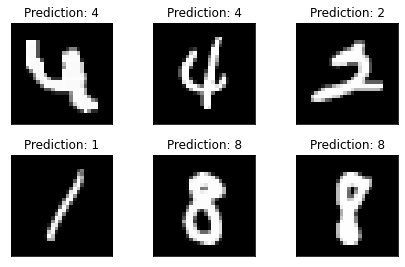

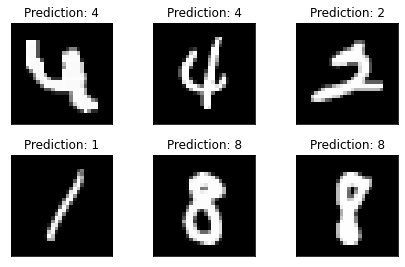

In [14]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig

### Continued Training from Checkpoints

In [15]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)


In [16]:
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)


In [17]:
for i in range(4,9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

<ipython-input-7-af7c11e03f8f>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.675229
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.201320
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.177006
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.324096
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.192962
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.239860
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.247139
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.323306
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.221996
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.277183
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.306056
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.274782
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.187950
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.332099
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.131845
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.283853
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.150553
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.411381
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.253669
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.360811
Train Epoch: 4 [12800/60000 (

Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.212255
Train Epoch: 5 [45440/60000 (76%)]	Loss: 0.156328
Train Epoch: 5 [46080/60000 (77%)]	Loss: 0.139911
Train Epoch: 5 [46720/60000 (78%)]	Loss: 0.104192
Train Epoch: 5 [47360/60000 (79%)]	Loss: 0.181890
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.226523
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.220654
Train Epoch: 5 [49280/60000 (82%)]	Loss: 0.234741
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.385243
Train Epoch: 5 [50560/60000 (84%)]	Loss: 0.156538
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.224296
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.232221
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.296779
Train Epoch: 5 [53120/60000 (88%)]	Loss: 0.124059
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.277374
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.141806
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.394075
Train Epoch: 5 [55680/60000 (93%)]	Loss: 0.150280
Train Epoch: 5 [56320/60000 (94%)]	Loss: 0.210798
Train Epoch: 5 [56960/60000 (95%)]	Loss: 0.376133


Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.130892
Train Epoch: 7 [29440/60000 (49%)]	Loss: 0.128358
Train Epoch: 7 [30080/60000 (50%)]	Loss: 0.170730
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.182025
Train Epoch: 7 [31360/60000 (52%)]	Loss: 0.520806
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.138741
Train Epoch: 7 [32640/60000 (54%)]	Loss: 0.135825
Train Epoch: 7 [33280/60000 (55%)]	Loss: 0.258551
Train Epoch: 7 [33920/60000 (57%)]	Loss: 0.151667
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.197507
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.139780
Train Epoch: 7 [35840/60000 (60%)]	Loss: 0.226226
Train Epoch: 7 [36480/60000 (61%)]	Loss: 0.149037
Train Epoch: 7 [37120/60000 (62%)]	Loss: 0.093356
Train Epoch: 7 [37760/60000 (63%)]	Loss: 0.157191
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.048980
Train Epoch: 7 [39040/60000 (65%)]	Loss: 0.161345
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.209658
Train Epoch: 7 [40320/60000 (67%)]	Loss: 0.159801
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.132315


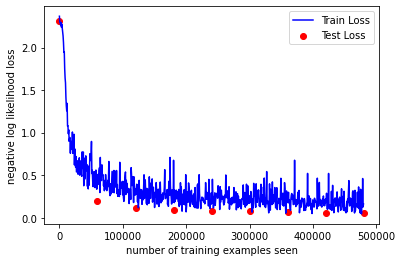

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig = plt.figure()

# test loss - measure of error encountered while predicting test cases
# train loss - measure of error encountered while training